In [14]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import copy

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, PCA
from sklearn.manifold import TSNE, MDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

Functions to output and save table, graph, and topic breakdowns given LDA model.

In [15]:
def topicBreakdown(df, lda):
    vocab = df.columns
    taxonomy = pd.read_csv('../metag_topic_modeling/data_sets/HMP_V13_taxonomy_fix.csv')
    result = ''

    for i, comp in enumerate(lda.components_):
        vocab_comp = zip(vocab, comp)
        sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
        result += ("Topic "+str(i)+": ")
        for t in sorted_words:
            row = taxonomy[taxonomy['OTU_ID'] == t[0]]
            if not row.empty:
                result += (str(row.iat[0, 6]) + ' ')
            else:
                result += ("Not Found")
        result += ("\n")

    print(result)

Original graph

In [16]:
body_sites = pd.read_csv('../metag_topic_modeling/data_sets/HMP_V13_participant_data.csv')

body_site_mapping = {site: idx for idx, site in enumerate(body_sites['HMP_BODY_SITE'].unique())}

body_site_ints = body_sites['HMP_BODY_SITE'].map(body_site_mapping)

In [17]:
df = pd.read_csv("../metag_topic_modeling/data_sets/HMP_V13_OTU_counts.csv")
df = df.drop(columns = ['PSN'])

# Standardize the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

# Initial dimensionality reduction
pca = PCA(n_components=50)
reduced_df = pca.fit_transform(scaled_df)

# Dimensionality reduction for visualization
tsne = TSNE(n_components=2, init='pca', random_state=0)
result = tsne.fit_transform(reduced_df)

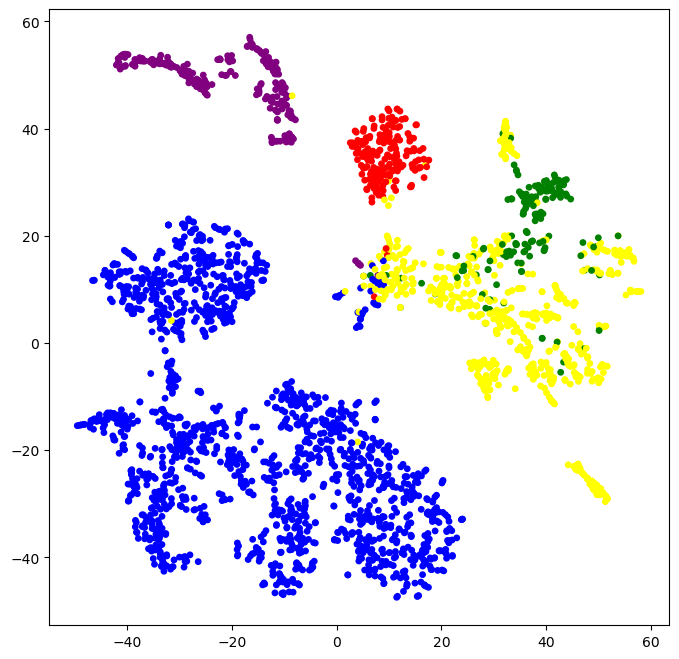

In [18]:
custom_colors = ['red', 'blue', 'green', 'yellow', 'purple']#, 'orange', 'pink', 'brown', 'olive', 'cyan']
cmap = ListedColormap(custom_colors)

# Plot with body sites
# Red = gut, blue = oral, green = airways, yellow = skin, purple = urogenital
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
scatter = plt.scatter(result[:, 0], result[:, 1], c=body_site_ints, cmap=cmap, s=15)
plt.savefig("body_site_plot.svg")
plt.show()

In [19]:
def outputTableandGraph(df, lda, filename):
    
    frequency_table = df.values
    topic_distributions = lda.transform(frequency_table)

    strongest_topic_indices = topic_distributions.argmax(axis=1)

    body_sites['Strongest_Topic'] = strongest_topic_indices

    topic_counts_by_site = body_sites.groupby(['HMP_BODY_SITE', 'Strongest_Topic']).size().unstack(fill_value=0)

    print(topic_counts_by_site)

    LDA_mapping = {site: idx for idx, site in enumerate(body_sites['Strongest_Topic'].unique())}

    LDA_ints = body_sites['Strongest_Topic'].map(LDA_mapping)

    custom_colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'olive', 'cyan']
    cmap = ListedColormap(custom_colors)

    fig = plt.figure(1, figsize=(8, 8))
    plt.clf()
    scatter = plt.scatter(result[:, 0], result[:, 1], c=LDA_ints, cmap=cmap, s=15)
    plt.savefig(filename + "_comp_plot_.svg")
    plt.show()

Function to find optimal component number for each taxonomic level by perplexity, returning a graph and a table at that level.

In [20]:
def findComponentNum(file_name):
    df = pd.read_csv('../metag_topic_modeling/data_sets/OTU_table_' + file_name + '.csv')
    df = df.drop(df.columns[0], axis=1)

    frequency_table = df.values

    bestLDA = LatentDirichletAllocation(n_components=5, random_state=0)
    bestLDA.fit(frequency_table)
    lowestPerplexity = bestLDA.perplexity(frequency_table)
    componentNum = 5
    print(componentNum, ',', lowestPerplexity, '\n')
    componentNum += 1


    decreasing = 1

    while decreasing == 1 and componentNum <= 10:
      LDA = LatentDirichletAllocation(n_components=componentNum, random_state=0)
      LDA.fit(frequency_table)
      perplexity = LDA.perplexity(frequency_table)

      print(componentNum, ', ', perplexity, '\n')
      
      if perplexity < lowestPerplexity:
        bestLDA = copy.deepcopy(LDA)
        lowestPerplexity = perplexity
      else:
        decreasing = 0

      componentNum += 1

    print('Component number:', componentNum - 2 + decreasing, ', Perplexity:', lowestPerplexity, '\n')

    return bestLDA, df

Combined function

In [21]:
def completeAnalysis(file_name):
    lda, df = findComponentNum(file_name)
    #topicBreakdown(df, lda)
    outputTableandGraph(df, lda, file_name)
    return df, lda

5 , 331457.99084284576 

6 ,  424116.1398171336 

Component number: 5 , Perplexity: 331457.99084284576 

Strongest_Topic         0    1    2    3    4
HMP_BODY_SITE                                
Airways                 2    0    0    0  159
Gastrointestinal Tract  0  186    0    0    1
Oral                    0    3    1  774  844
Skin                    2    9    1    5  647
Urogenital Tract        0    1  115  145    3


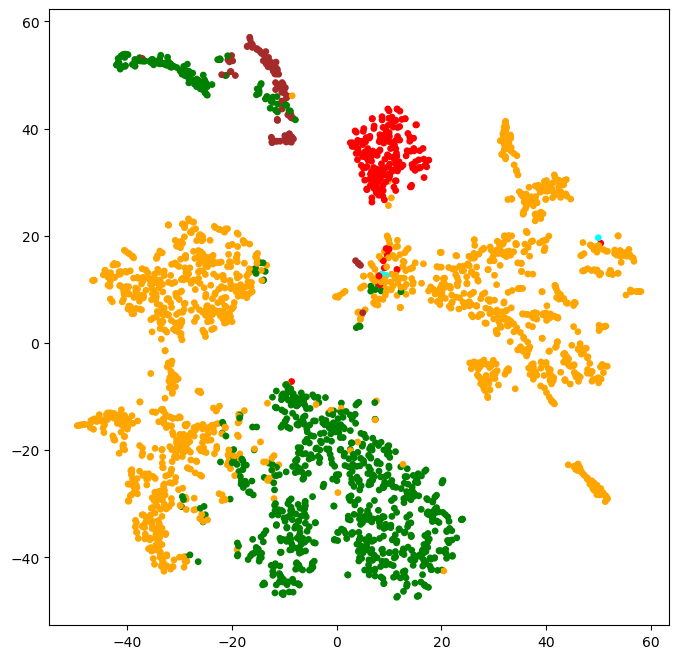

In [28]:
TSS_df, TSS_lda = completeAnalysis('TSS')

In [23]:
#CLR_df, CLR_lda = completeAnalysis('CLR') has negative values

ValueError: Negative values in data passed to LatentDirichletAllocation.fit

In [29]:
Log10_df, Log10_lda = completeAnalysis('Log10')

5 , 3051681.7534014923 

6 ,  5536276.148654061 

Component number: 5 , Perplexity: 3051681.7534014923 



ValueError: Length of values (999) does not match length of index (2898)

In [25]:
# Z_df, Z_lda = completeAnalysis('Z') has negative values

ValueError: Negative values in data passed to LatentDirichletAllocation.fit